# Detecting humorous reviews at Yelp

In this project we examine how to make models that can classify if a review is funny or not.
The actual [dataset](https://www.yelp.com/dataset_challenge) contains 4 million reviews by 1 million users for 144k businesses.

In the next section how a random sample from it with 10000 reviews looks like:


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import os
import sys
import numpy as np
import itertools
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
os.chdir(nb_dir)

In [2]:
df_small = pd.read_csv('data/processed/yelp_subset.csv')
df_small.head()

,Unnamed: 0,funny,user_id,review_id,text,business_id,stars,date,useful,type,cool
0,1234684,0,KWY0QyEXEMGh6xCB5oMUzg,NdbkPVe_xrd8TFrggN6_xg,I always like the pizza. Service is usually g...,0PMKMyfX1j7Nc4esk1RaMg,4,2014-08-08,0,review,0
1,3188601,0,ZmFZlgHrs23eRZGA3LDKfQ,wRuvsAe2npOF6j4H5pB81g,"I liked the decor, but the place was fairly em...",X-_KD0nInfFQYa7MPZE3cQ,2,2013-01-02,1,review,0
2,2861441,3,0zZk826vbqYCx_yV8WGvtw,ZC2BIZcp7VqyP1JeiGC6_g,This chain is one of the better boba places I'...,IZivKqtHyz4-ts8KsnvMrA,4,2016-01-01,4,review,3
3,337096,0,jPVYZXiAeIUYS9rBhtiLZw,EVg_yqi7CTK46-haToEKzg,"Dear Mr. Giroux,\nYou have all of our family t...",wbuW38I-B6V8mbxrae2wiw,1,2014-07-14,0,review,0
4,3808496,0,29v2GjByL9e20myiBm0C3A,-xeRTRTD5158HODDMKxwAQ,Amazing service. Moer got to my house within 1...,NA-9WSNjAqJVzpgC29xURQ,5,2016-04-01,0,review,0


In [3]:
df_small.funny.value_counts()

0     8125
1     1141
2      343
3      142
4       81
5       51
6       24
7       22
8       15
9       11
11       9
10       9
13       5
15       5
12       4
16       4
14       2
17       1
18       1
49       1
53       1
26       1
27       1
55       1
Name: funny, dtype: int64

In [4]:
# We consider a video funny if more than 3 people voted for it as funny
# and write the result
df_small['funny_flag'] = 0
df_small.ix[df_small.funny >= 3, 'funny_flag'] = 1
# df_small.to_csv('data/processed/yelp_subset_with_flag.csv')

In [5]:
df_small.funny_flag.value_counts()

0    9609
1     391
Name: funny_flag, dtype: int64

### Examples of humorous comments

In [6]:
for i, s in enumerate(df_small.sort_values('funny', ascending=False).text.head(5).tolist()):
    print('Review {0}:\n {1}\n\n'.format(i,s))

Review 0:
 My favorite free attraction in Vegas.  Yes, even beating the street people giving out cards with naked women on them J/K ;p

The Fountains of Bellagio are located in the heart of the Strip, where visitors can enjoy a beautiful display of water being shot high into the sky, in tune with music.  
http://www.vegas.com/attractions/on-the-strip/bellagio-fountains/

Strolling along the Strip, especially at night, it's a great sight to behold, whether with friends or your significant other.  Last time I was there, we saw the Fountains with Michael Jackson's "Billie Jean" playing.  Later on, on the way back to our hotel, we saw it again with Celine Dion's "My Heart Will Go On".  Such an extravagant spectacle for the senses!  There's just something about an oasis of moving water right before your eyes in the middle of the searing desert,  music tickling your tympanic membranes.  All for free!

Great views from the front of Bellagio, or when dining at Mon Ami Gabi at Paris.  The show 

In [7]:
print('Number of funny videos:', len(df_small[df_small.funny_flag == 1]))

Number of funny videos: 391


In [8]:
print('Number of not funny videos:', len(df_small[df_small.funny_flag == 0]))

Number of not funny videos: 9609


In [9]:
funny = df_small[df_small.funny_flag == 1].text.dropna().to_string()

In [30]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=1200,
                      height=1000
                      ).generate(funny)

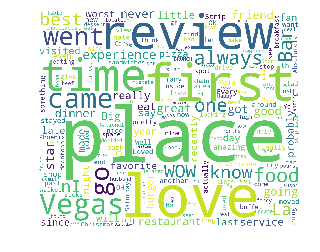

In [31]:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [32]:
plt.imsave('wordcloud.png', wordcloud)

## Small and big datasets

The 'small' dataset is the one shown above with 10000 reviews in total drawn from the big one. We name `tag` the variable that shows if we speak about the `small` or `big` datasets

In [10]:
# Import the utilities we have
from yelp_ds import yelp_runner

## Making the datasets

In [11]:
tag = 'small'
cores = 6

In [35]:
x_train, x_test, y_train, y_test = yelp_runner.create_train_test_datasets(tag)

Train and test datasets in place.


## Create bag of words and tf-idf corpuses

### Bag-of-words (BOW model)
- In the bag of words model, each word is associated with an id
- Each document has as features all dictionary words and the weights are the number of occurrences in the document
- With logistic regression it achieves 76% accuracy for the small model and almost 79% for the full one
- It’s simple to implement but consumes lots of memory


### TF-IDF model

- Tf-idf is based on the idea of representing how important is a word to a document in a corpus
- Term frequency (tf) means we count the number of times the term appears in a document
- Inverse document frequency (idf) we multiply tf of a word by the inverse document frequency to distinguish how meaningful is a word for a document
- Simple but achieves  good results 79% - 80% accuracy in both small and big datasets


In [12]:
mm_corpus_bow, mm_corpus_tfidf = yelp_runner.create_bow_tfidf_corpuses(tag)

Dictionary exists, loading...
Bag of words corpus exists, loading...
Tf-Idf corpus exists, loading...


## Train Logistic Regression over bag-of-words and tf-idf

In [13]:
bow = yelp_runner.train_logistic_regression_bow(tag, cores)
tfidf = yelp_runner.train_logistic_regression_tfidf(tag, cores)


Dictionary exists, loading...
Bag of words corpus exists, loading...
Tf-Idf corpus exists, loading...
Logistic regression for bow exists, loading...
Dictionary exists, loading...
Bag of words corpus exists, loading...
Tf-Idf corpus exists, loading...
Logistic Regression model for tfidf exists, loading...


## Predictions and metrics for bow and tf-idf trained with Logistic Regression

In [30]:
p_metrics_bow, p_metrics_conf_matrix_bow, p_metrics_tfidf, p_metrics_conf_matrix_tfidf, y_pred_bow, y_pred_tfidf = yelp_runner.predict_bow_tfidf(tag)

Dictionary exists, loading...
Bag of words corpus exists, loading...
Tf-Idf corpus exists, loading...
Logistic regression for bow exists, loading...
Dictionary exists, loading...
Bag of words corpus exists, loading...
Tf-Idf corpus exists, loading...
Logistic Regression model for tfidf exists, loading...
Predictions exist, loading...
name: bow - accuracy: 0.953 
name: tfidf - accuracy: 0.9575 
confusion matrix bow:
[[1903   12]
 [  82    3]]
confusion matrix tfidf: 
[[1915    0]
 [  85    0]]


In [31]:
tp1 = 1903
fp1 = 82
fn1 = 12
tp2 = 1915
fp2 = 85
fn2 = 0
def precision(tp, fp): return tp / (tp + fp)
def recall(tp, fn): return tp / (tp + fn)
def f1(tp, fp, fn): prec = precision(tp, fp); rec = recall(tp, fn); return 2 * prec * rec / (prec + rec)
print('bow f1 score: {0}'.format(f1(tp1, fp1, fn1)))
print('tfidf f1 score: {0}'.format(f1(tp2, fp2, fn2)))

bow f1 score: 0.9758974358974359
tfidf f1 score: 0.9782886334610472


As we see both the accuracy and f1 scores are really good even for the subset of the dataset

In [50]:
# Successful example
y_test = np.array(y_test)
y_pred_bow = np.array(y_pred_bow)
y_pred_tfidf = np.array(y_pred_tfidf)
x_test = np.array(x_test)
false_positives_bow = x_test[(y_test == 0) & (y_pred_bow == 1)]
false_negatives_bow = x_test[(y_test == 1) & (y_pred_bow == 0)]

print('Example of false positive in bow:')
print(false_positives_bow[0])
print('\nExample of false negative in bow:')
print(false_negatives_bow[0])

false_positives_tfidf = x_test[(y_test == 0) & (y_pred_tfidf == 1)]
false_negatives_tfidf = x_test[(y_test == 1) & (y_pred_tfidf == 0)]

print('\nExample of false positive in bow:')
if false_positives_tfidf: 
    print(false_positives_tfidf[0]) 
else: print('No false positives')
print('\nExample of false negative in bow:')
print(false_negatives_tfidf[0])


Example of false positive in bow:
I'm not a cheese connoisseur by any means but I feel like cheese is necessary when serving charcuteries, so occasionally I like to buy a wedge here and there. I live in the College Park area, so my usual spot to go to is the giant Loblaws at Maple Leaf Gardens where they have a big cheese wall with a good selection of cheeses - but today I happened to be in Kensington, accidentally stumbled upon this place, and realized that I've been getting ripped off!

I bought a 200g wedge of coconut brie (which actually tastes like coconuts), goat cheese, Oka, and a cup of shredded cheese and it all came to only $20!! It would've cost easily twice as much at a Loblaw's or a Whole Foods. I realized that I could even Uber here and back for the same amount of money I'd be spending at Loblaws, while having wider selection of cheeses.

Everyone there was really helpful, and they were happy to give me recommendations when I asked. The layout of the store is quite open s

## Create doc2vec models

Doc2vec is an unsupervised algorithm to generate features for sentences/paragraphs/documents
- For sentence similarity it may perform well, however if there are many misspellings it might not be the ideal choice
- It is very memory efficient and if it is trained with tuned parameters it can perform very well
- In our dataset we try 3 different doc2vec models. 80% accuracy is achieved in both models


In [22]:
models = yelp_runner.create_and_train_models_d2vec(tag, cores)

Models exist, loading...


## Train Logistic Regression on doc2vec

Logistic Regression is a model we can use for dependent variables that are categories, here funny and not funny.

In [23]:
lrs = yelp_runner.train_logistic_regression_d2vec(tag, cores)

Models exist, loading...
Models exist, loading...
Train corpuses exist, loading...
Train corpuses exist, loading...
Train corpuses exist, loading...
Logistic Regression model exists, loading...
Logistic Regression model exists, loading...
Logistic Regression model exists, loading...


## Predictions and metrics for doc2vec

In [51]:
p_metrics_conf_matrix, p_metrics, y_preds = yelp_runner.predictions_d2vec(tag)

Models exist, loading...
Test corpuses exist, loading...
Test corpuses exist, loading...
Test corpuses exist, loading...
Models exist, loading...
Models exist, loading...
Train corpuses exist, loading...
Train corpuses exist, loading...
Train corpuses exist, loading...
Logistic Regression model exists, loading...
Logistic Regression model exists, loading...
Logistic Regression model exists, loading...
Models exist, loading...
Making predictions...
name: Doc2Vec(dmc_d100_n5_w5_mc2_s0.001_t6) - accuracy: 0.9575 - f1: OrderedDict([('Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t6)', 'Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t6)'), ('Doc2Vec(dbow,d100,n5,mc2,s0.001,t6)', 'Doc2Vec(dbow,d100,n5,mc2,s0.001,t6)'), ('Doc2Vec(dm/m,d100,n5,w10,mc2,s0.001,t6)', 'Doc2Vec(dm/m,d100,n5,w10,mc2,s0.001,t6)')])
name: Doc2Vec(dmc_d100_n5_w5_mc2_s0.001_t6) - confusion matrix:
[[1915    0]
 [  85    0]]
Making predictions...
name: Doc2Vec(dbow_d100_n5_mc2_s0.001_t6) - accuracy: 0.9575 - f1: OrderedDict([('Doc2Vec(dm/c,d10

In [27]:
print('First doc2vec model f1: {0}'.format(f1(1915, 85, 0)))
print('Second doc2vec model f1: {0}'.format(f1(1915, 85, 0)))
print('Third doc2vec model f1: {0}'.format(f1(1199, 59, 716)))

First doc2vec model f1: 0.9782886334610472
Second doc2vec model f1: 0.9782886334610472
Third doc2vec model f1: 0.7557516545855657


In [60]:
y_test = np.array(y_test)
y_pred = np.array(y_preds['Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t6)'])

false_positives_d2vec = x_test[(y_test == 0) & (y_pred == 1)]
false_negatives_d2vec = x_test[(y_test == 1) & (y_pred == 0)]

print('Example of false positive in doc2vec:')
if false_positives_d2vec:
    print(false_positives_d2vec[0])
else:
    print('No false positives')
print('\nExample of false negative in bow:')
print(false_negatives_d2vec[0])

Example of false positive in doc2vec:
No false positives

Example of false negative in bow:
So, all week before my Vegas trip I was super pumped about a schmancy $100 brunch reservation we had at some other restaurant. It turned out to be okay, but that night we went to Johnny Smalls for a $20 all-you-can-eat tapas dinner and it blew that fancy schmancy brunch out of the effin' water.

Seriously. This is approximately three billion times better than any buffet out there. I know some of ya'll are really into foie gras, caviar, and whatever other hoity-toitiness there is out there. You know what I'm into? Mac n' cheese, bacon, fritos, ranch dressing. What can I say? I'm a gal of highly refined taste, and Johnny Smalls has got my number

There was a 20 minute wait for a table, so we sidled on up to the bar and had dinner and drinks there all served by Anthony, the most kickass flair bartender/server EVER. And you know how I mentioned that $20 AYCE earlier? It really is AYCE. Anything on t

## References

- https://www.yelp.com/dataset_challenge
- https://cs224d.stanford.edu/reports/OliveiraLuke.pdf
- https://radimrehurek.com/gensim/models/doc2vec.html
- https://cs.stanford.edu/~quocle/paragraph_vector.pdf
